In [35]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.nn import functional as F
import timm
import os
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.optim import Adam
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from collections import Counter
import os
import seaborn as sns
from PIL import Image
import numpy as np


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:

# Define class labels
class_labels = {
    "Hatchback": 0,
    "Other": 1,
    "Pickup": 2,
    "Sedan": 3,
    "SUV": 4
}


In [38]:

# Define image size
IMG_SIZE = 224


In [39]:
# Função para analisar as imagens
def analyze_images(image_dir):
    dataset = ImageFolder(image_dir)
    
    # Contar as classes
    class_counts = Counter([item[1] for item in dataset.imgs])
    
    # Tamanho das imagens
    image_sizes = [Image.open(item[0]).size for item in dataset.imgs]
    
    # Tamanho médio das imagens
    avg_width = np.mean([size[0] for size in image_sizes])
    avg_height = np.mean([size[1] for size in image_sizes])
    
    # Exibir resultados
    print(f"Total number of images: {len(dataset)}")
    print(f"Class distribution: {class_counts}")
    print(f"Average image size: {avg_width:.2f} x {avg_height:.2f}")
    
    # Plotar distribuição das classes
    plt.bar(class_counts.keys(), class_counts.values(), tick_label=[dataset.classes[i] for i in class_counts.keys()])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

Total number of images: 4793
Class distribution: Counter({2: 1689, 4: 1222, 3: 680, 0: 602, 1: 600})
Average image size: 375.81 x 291.92


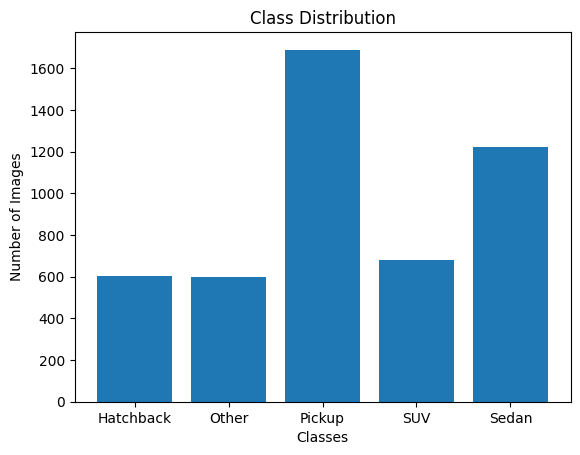

In [40]:
image_dir = './vehicles'  
# Analisar o dataset
analyze_images(image_dir)

In [41]:

# Preprocess images and labels
def preprocess_data(image_dir, class_labels, batch_size=32, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = ImageFolder(image_dir, transform=transform)
    
    # Split dataset into train/test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # Create DataLoader for train and test datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [42]:

def generate_embeddings(loader, model, device):
    model.eval()
    embeddings = []
    targets = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            embeddings.append(outputs.cpu())
            targets.append(labels.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    targets = torch.cat(targets, dim=0)
    return embeddings, targets


In [43]:

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [44]:

# Função para treinar o modelo com early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), 'checkpoint.pt')


In [45]:

def evaluate_model(model, test_embeddings, test_targets, device):
    model.eval()
    test_embeddings = test_embeddings.to(device)
    test_targets = test_targets.to(device)
    with torch.no_grad():
        outputs = model(test_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total = test_targets.size(0)
        correct = (predicted == test_targets).sum().item()

        # Cálculo de métricas adicionais
        precision = precision_score(test_targets.cpu(), predicted.cpu(), average='macro')
        recall = recall_score(test_targets.cpu(), predicted.cpu(), average='macro')
        f1 = f1_score(test_targets.cpu(), predicted.cpu(), average='macro')
        conf_matrix = confusion_matrix(test_targets.cpu(), predicted.cpu())

        

    accuracy = 100 * correct / total
    return accuracy, precision, recall, f1, conf_matrix


In [46]:
# Criar o modelo ViT pré-treinado
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)


vit_model = vit_model.to(device)


In [47]:
train_loader, test_loader=train_loader, test_loader = preprocess_data(image_dir, class_labels, batch_size=16)


train_embeddings, train_targets = generate_embeddings(train_loader, vit_model, device)
test_embeddings, test_targets = generate_embeddings(test_loader, vit_model, device)

# Dimensões de entrada e saída
input_dim = train_embeddings.shape[1]
output_dim = len(class_labels)
hidden_dim = 512  # Dimensão da camada oculta (ajuste conforme necessário)

In [48]:

# Crie o modelo
mlp = MLP(input_dim, hidden_dim, output_dim).to(device)


In [49]:

# Função de Loss, Otimizador e epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)



In [50]:

# Inicializar listas para monitorar perda e acurácia
train_loss = []
valid_loss = []


In [51]:
def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Avaliação antes do treinamento:


Initial Test Accuracy: 17.21 %
Initial Precision: 0.22
Initial Recall: 0.24
Initial F1 Score: 0.13
Initial Confusion Matrix:
[[ 35  81   0   8   0]
 [  4 113   7  11   3]
 [ 63 260  10   3   0]
 [ 34  56   0   7   1]
 [120 138   0   5   0]]


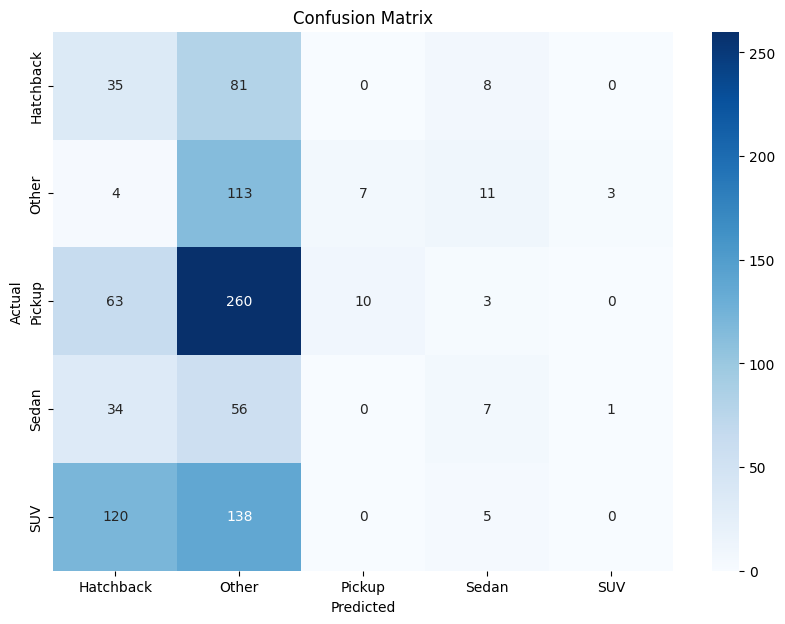

In [52]:

# Avaliar o modelo antes do treinamento
print("Avaliação antes do treinamento:")
initial_accuracy, initial_precision, initial_recall, initial_f1, initial_conf_matrix = evaluate_model(mlp, test_embeddings, test_targets, device)
print(f'Initial Test Accuracy: {initial_accuracy:.2f} %')
print(f'Initial Precision: {initial_precision:.2f}')
print(f'Initial Recall: {initial_recall:.2f}')
print(f'Initial F1 Score: {initial_f1:.2f}')
print(f'Initial Confusion Matrix:\n{initial_conf_matrix}')

# Plotar a matriz de confusão
plot_confusion_matrix(initial_conf_matrix, list(class_labels.keys()))


In [53]:

num_epochs = 10000
patience = 5  # Paciencia para early stopping
early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

for epoch in range(num_epochs):
    mlp.train()
    train_embeddings = train_embeddings.to(device)
    train_targets = train_targets.to(device)

    # Forward pass
    outputs = mlp(train_embeddings)
    loss = criterion(outputs, train_targets)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save training loss
    train_loss.append(loss.item())

    # Validation
    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(train_embeddings)
        val_loss = criterion(val_outputs, train_targets)
        valid_loss.append(val_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    early_stopping(val_loss, mlp)
    if early_stopping.early_stop:
        print("Early stopping")
        break


Epoch [1/10000], Loss: 1.6256, Val Loss: 1.2673
Epoch [2/10000], Loss: 1.2673, Val Loss: 1.0266
Epoch [3/10000], Loss: 1.0266, Val Loss: 0.7990
Epoch [4/10000], Loss: 0.7990, Val Loss: 0.6641
Epoch [5/10000], Loss: 0.6641, Val Loss: 0.5885
Epoch [6/10000], Loss: 0.5885, Val Loss: 0.5282
Epoch [7/10000], Loss: 0.5282, Val Loss: 0.4844
Epoch [8/10000], Loss: 0.4844, Val Loss: 0.4403
Epoch [9/10000], Loss: 0.4403, Val Loss: 0.3938
Epoch [10/10000], Loss: 0.3938, Val Loss: 0.3657
Epoch [11/10000], Loss: 0.3657, Val Loss: 0.3275
Epoch [12/10000], Loss: 0.3275, Val Loss: 0.3148
Epoch [13/10000], Loss: 0.3148, Val Loss: 0.2824
Epoch [14/10000], Loss: 0.2824, Val Loss: 0.2618
Epoch [15/10000], Loss: 0.2618, Val Loss: 0.2289
Epoch [16/10000], Loss: 0.2289, Val Loss: 0.2145
Epoch [17/10000], Loss: 0.2145, Val Loss: 0.1941
Epoch [18/10000], Loss: 0.1941, Val Loss: 0.1777
Epoch [19/10000], Loss: 0.1777, Val Loss: 0.1580
Epoch [20/10000], Loss: 0.1580, Val Loss: 0.1470
Epoch [21/10000], Loss: 0.147

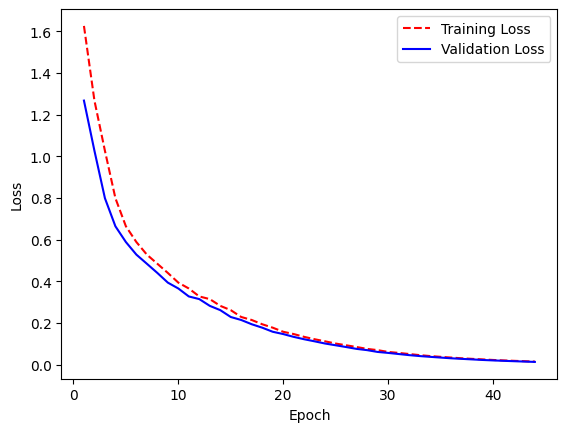

In [54]:

# Visualizar histórico de perda
epoch_count = range(1, len(train_loss) + 1)
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [55]:

# Carregar o melhor modelo salvo durante o early stopping
mlp.load_state_dict(torch.load('checkpoint.pt'))


<All keys matched successfully>

Avaliação após o treinamento:
Final Test Accuracy: 98.33 %
Final Precision: 0.98
Final Recall: 0.98
Final F1 Score: 0.98
Final Confusion Matrix:
[[118   0   0   0   6]
 [  0 137   0   1   0]
 [  0   0 336   0   0]
 [  2   0   0  94   2]
 [  2   0   1   2 258]]


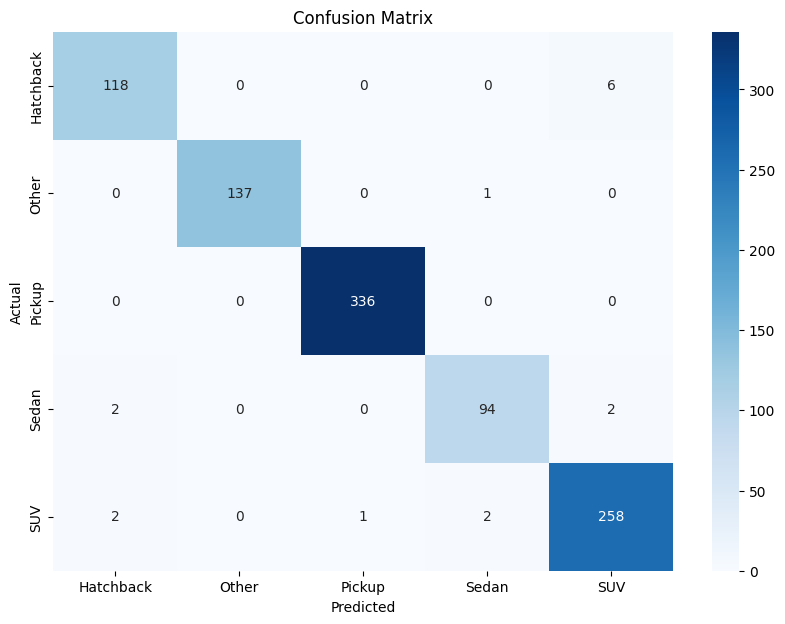

In [56]:
print("Avaliação após o treinamento:")
final_accuracy, final_precision, final_recall, final_f1, final_conf_matrix = evaluate_model(mlp, test_embeddings, test_targets, device)
print(f'Final Test Accuracy: {final_accuracy:.2f} %')
print(f'Final Precision: {final_precision:.2f}')
print(f'Final Recall: {final_recall:.2f}')
print(f'Final F1 Score: {final_f1:.2f}')
print(f'Final Confusion Matrix:\n{final_conf_matrix}')

# Plotar a matriz de confusão
plot_confusion_matrix(final_conf_matrix, list(class_labels.keys()))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total images loaded: 959
Incorrect indices: [18, 103, 119, 206, 301, 356, 388, 443, 457, 536, 539, 589, 741, 776, 840, 936]
True labels: [3, 1, 4, 3, 4, 4, 3, 4, 0, 0, 0, 3, 0, 4, 0, 0]
Predicted labels: [0, 3, 0, 0, 3, 2, 4, 3, 4, 4, 4, 4, 4, 0, 4, 4]

Número de imagens incorretamente classificadas: 16



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

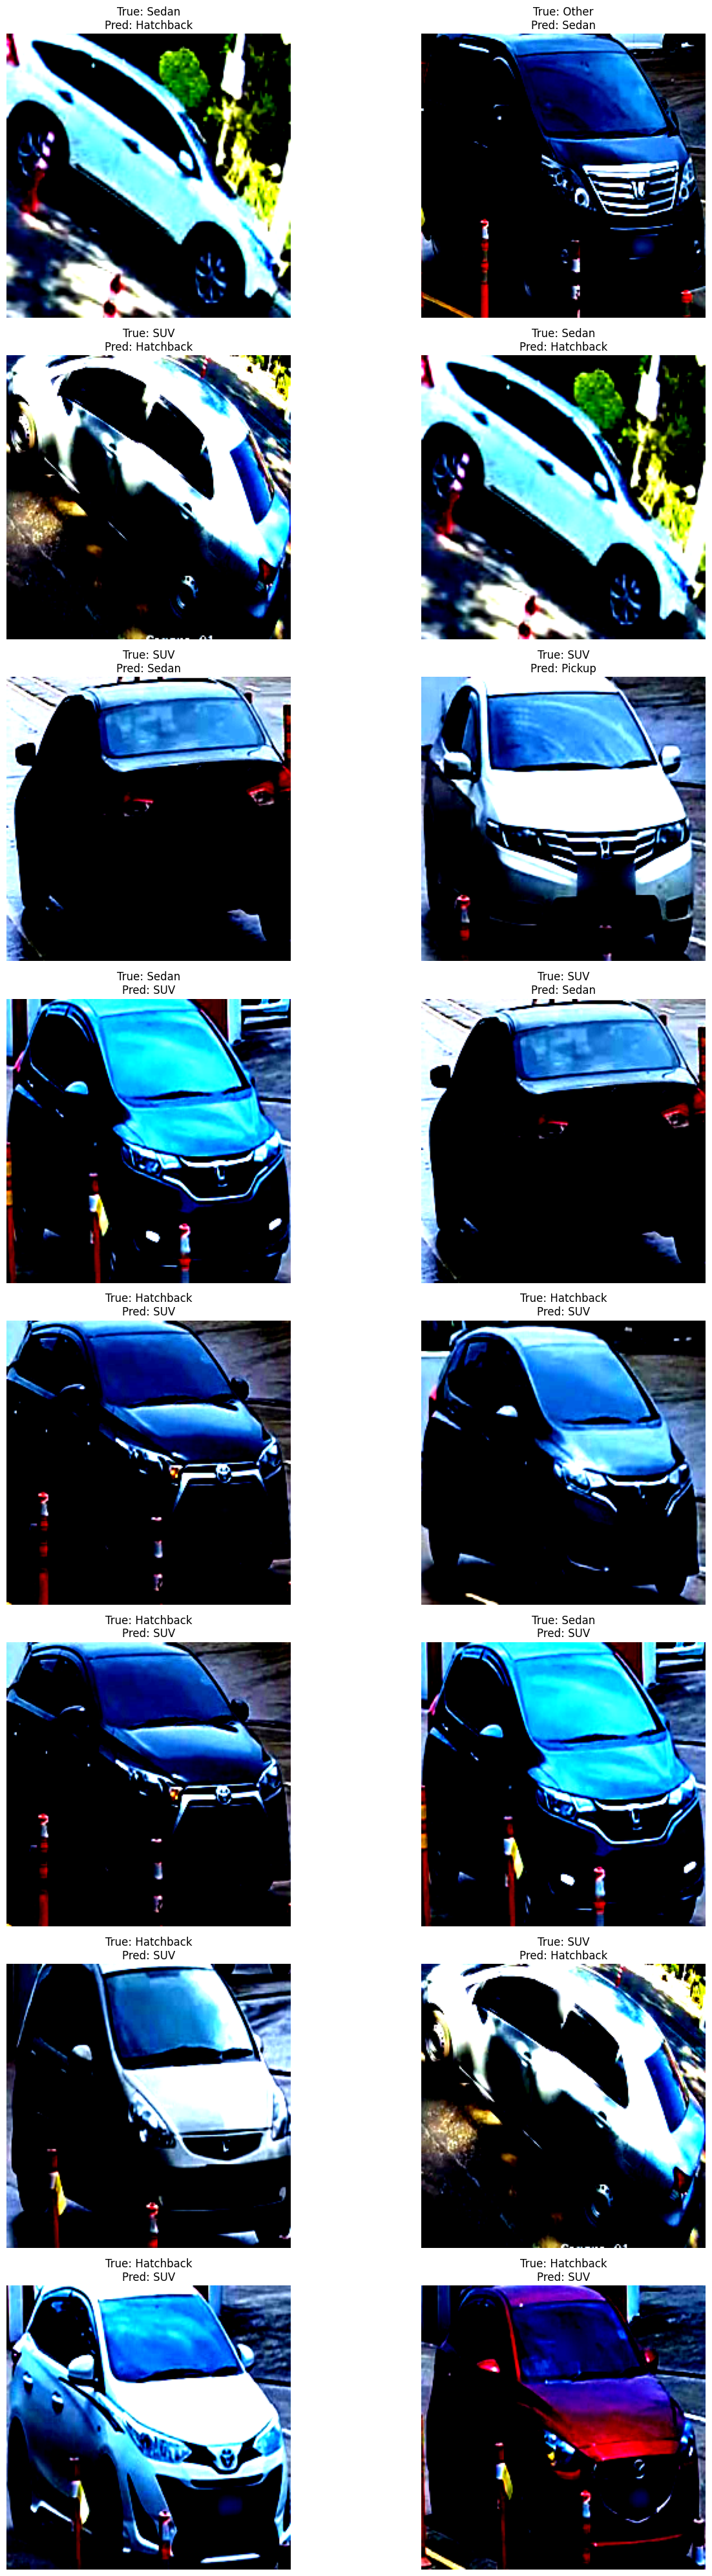

In [89]:
# Identificar amostras incorretamente classificadas
incorrect_indices = []
true_labels = []
pred_labels = []
class_labels_inv = {v: k for k, v in class_labels.items()}

mlp.eval()
with torch.no_grad():
    for i, (embedding, target) in enumerate(zip(test_embeddings, test_targets)):
        output = mlp(embedding.unsqueeze(0).to(device))
        predicted = torch.argmax(output, dim=1).item()
        true_label = target.item()
        if predicted != true_label:
            incorrect_indices.append(i)
            true_labels.append(true_label)
            pred_labels.append(predicted)

# Carregar todas as imagens de test_loader em uma lista
test_images = []
test_targets_list = []
for images, targets in test_loader:
    test_images.extend(images)
    test_targets_list.extend(targets)

# Verificação de dados
print(f"Total images loaded: {len(test_images)}")
print(f"Incorrect indices: {incorrect_indices}")
print(f"True labels: {true_labels}")
print(f"Predicted labels: {pred_labels}")

# Mostrar imagens incorretamente classificadas
num_incorrect = len(incorrect_indices)
print(f'\nNúmero de imagens incorretamente classificadas: {num_incorrect}\n')

# Ajustar o número de colunas para ter no máximo 2 colunas
num_cols = 2
num_rows = (num_incorrect + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for ax, idx, true_label, pred_label in zip(axes, incorrect_indices, true_labels, pred_labels):
    ax.imshow(test_images[idx].cpu().permute(1, 2, 0))  # Acessa a imagem pelo índice
    true_class = class_labels.get(true_label, f'{true_label}')
    pred_class = class_labels.get(pred_label, f'{pred_label}')
    
    true_class2 = class_labels_inv.get(true_label, f'Unknown({true_label})')
    pred_class2 = class_labels_inv.get(pred_label, f'Unknown({pred_label})')

    ax.set_title(f'True: {true_class2}\nPred: {pred_class2}')
    ax.axis('off')

# Desativar eixos vazios
for i in range(num_incorrect, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()